In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [6]:
import yfinance as yf

df = yf.download("HCLTECH.NS", period="8y", interval="1d")
csv_path = "/content/drive/MyDrive/Colab Notebooks/HCL_8y(17-25).csv"
df.to_csv(csv_path)
df

/tmp/ipython-input-6-4228837724.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("HCLTECH.NS", period="8y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,HCLTECH.NS,HCLTECH.NS,HCLTECH.NS,HCLTECH.NS,HCLTECH.NS
Date,,,,,
2017-07-04,343.729523,347.160497,342.279537,346.527407,1981500
2017-07-05,342.075348,343.586611,341.095062,342.688020,2420508
2017-07-06,343.361877,344.076662,341.340055,343.096376,1373060
2017-07-07,339.787933,343.300577,338.521729,343.300577,2303234
2017-07-10,347.037933,348.732978,342.279503,342.442892,390438
...,...,...,...,...,...
2025-06-30,1728.599976,1734.800049,1713.300049,1725.000000,1855229
2025-07-01,1718.300049,1745.000000,1714.000000,1728.599976,1639826


In [7]:
df_clean = df[['Open', 'High', 'Close']]
df_clean

Price,Open,High,Close
Ticker,HCLTECH.NS,HCLTECH.NS,HCLTECH.NS
Date,,,
2017-07-04,346.527407,347.160497,343.729523
2017-07-05,342.688020,343.586611,342.075348
2017-07-06,343.096376,344.076662,343.361877
2017-07-07,343.300577,343.300577,339.787933
2017-07-10,342.442892,348.732978,347.037933
...,...,...,...
2025-06-30,1725.000000,1734.800049,1728.599976
2025-07-01,1728.599976,1745.000000,1718.300049


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

def plot_graph(df_clean):

    # Closing prices for 8 years
    plt.figure(figsize=(12,5))
    plt.plot(df_clean.index, df_clean['Close'], color='blue')
    plt.title("Stock Prices of Last 8 Years")
    plt.xlabel("Date")
    plt.ylabel("Closing Prices")
    plt.show()

    print("\n")

    # Trend, Seasonality, Residual Plot
    close_series = df_clean["Close"].dropna()
    decomposition = seasonal_decompose(close_series, model='multiplicative', period=252)

    plt.figure(figsize=(12,8))

    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend, color='black')
    plt.title("Trend")

    print("\n\n")

    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal, color='orange')
    plt.title("Seasonality")

    print("\n\n")

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid, color='red')
    plt.title("Residual (Noise)")
    plt.show()

    print("\n\n")
    # PACF Plot
    plt.figure(figsize=(12, 5))
    plot_pacf(close_series, lags=30, method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    plt.show()

    print("\n\n\n")

    # 20-day moving average
    df_clean['MA_30'] = df_clean['Close'].rolling(window=30).mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Close'], label='Close Price', linewidth=1.5)
    plt.plot(df_clean['MA_30'], label='30-Day Moving Average', color='orange', linewidth=2)
    plt.title('Close Price vs 30-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

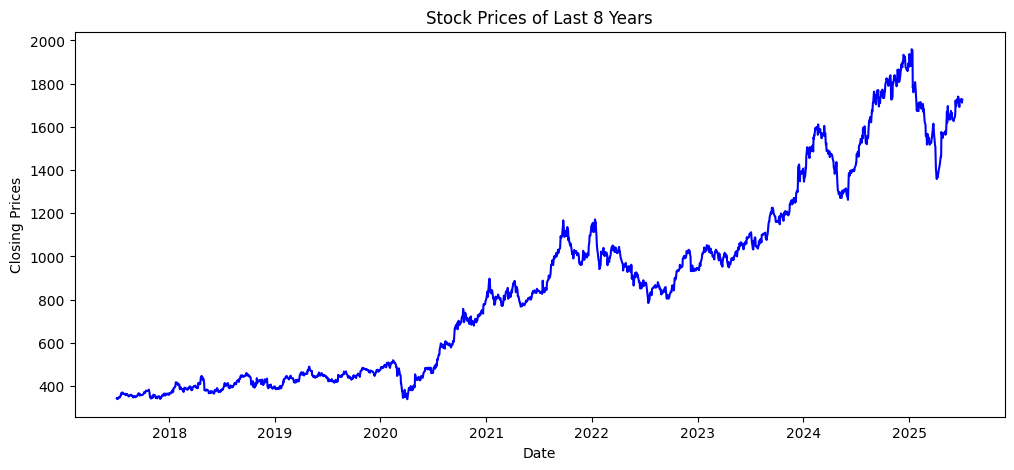

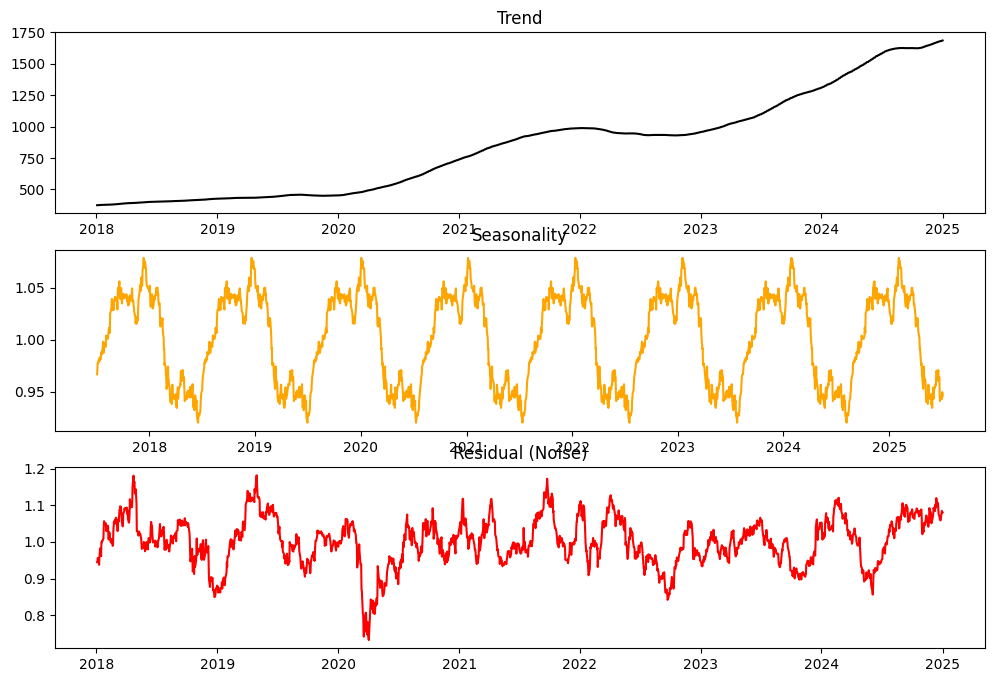

<Figure size 1200x500 with 0 Axes>

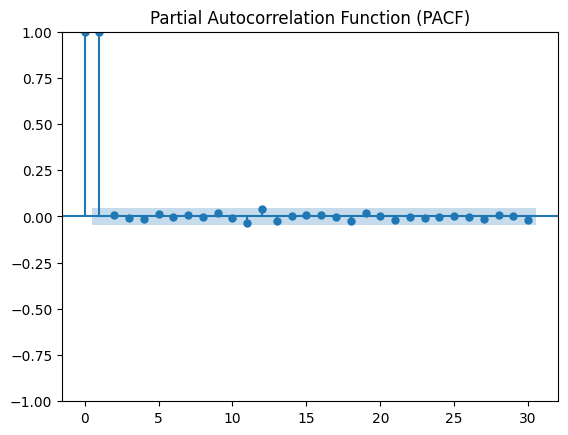

/tmp/ipython-input-8-1393624469.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MA_30'] = df_clean['Close'].rolling(window=30).mean()


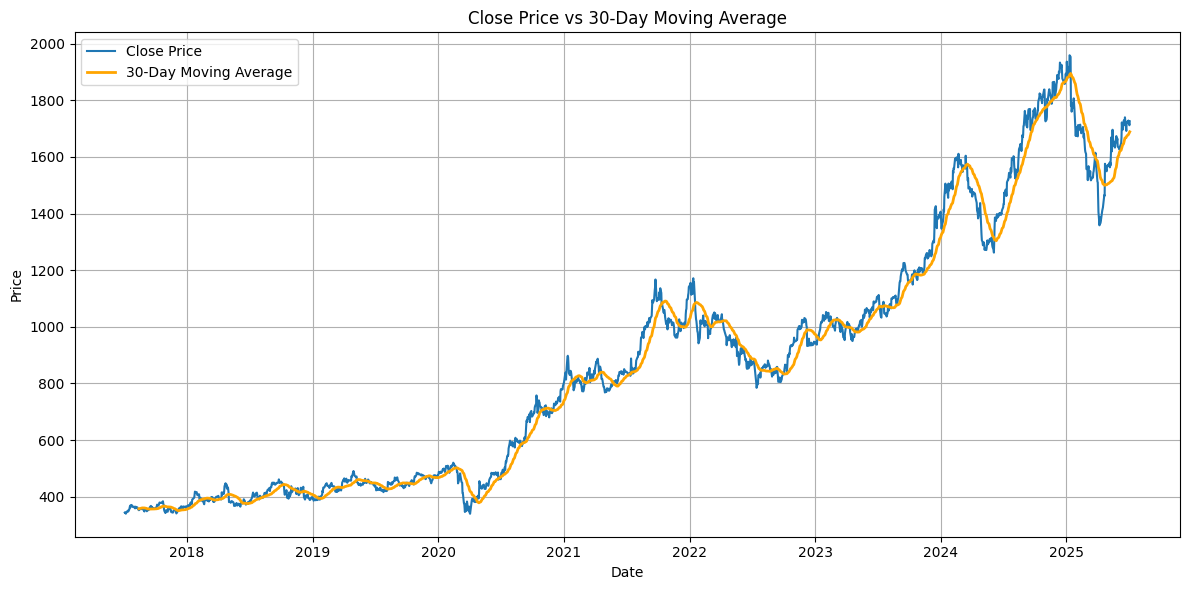

In [9]:
plot_graph(df_clean)

In [10]:
import pandas as pd
import numpy as np

def split_df_clean(df_clean, train_ratio=0.875, val_ratio=0.0625):

    df_clean = df_clean[['Open', 'High', 'Close']].dropna().copy()

    total_len = len(df_clean)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)

    df_train = df_clean.iloc[:train_end]
    df_val   = df_clean.iloc[train_end:val_end]
    df_test  = df_clean.iloc[val_end:]

    return df_train, df_val, df_test

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_stock_data_lstm(df_split, lags=30, scaler=None, is_train=True):
    df_split = df_split[['Open', 'High', 'Close']].dropna().copy()

    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df_split)
    else:
        scaled_values = scaler.transform(df_split)

    df_scaled = pd.DataFrame(scaled_values, columns=['Open', 'High', 'Close'], index=df_split.index)

    X, y = [], []
    for i in range(lags, len(df_scaled)):
        X.append(df_scaled.iloc[i-lags:i].values)
        y.append(df_scaled.iloc[i]['Close'])

    return np.array(X), np.array(y), scaler

In [12]:
df_train, df_val, df_test = split_df_clean(df_clean)

X_train, y_train, hcl_scaler = preprocess_stock_data_lstm(df_train, lags=30, scaler=None, is_train=True)
X_val, y_val, _               = preprocess_stock_data_lstm(df_val,   lags=30, scaler=hcl_scaler, is_train=False)
X_test, y_test, _             = preprocess_stock_data_lstm(df_test,  lags=30, scaler=hcl_scaler, is_train=False)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1700, 30, 3) (1700,)
Val  : (93, 30, 3) (93,)
Test : (95, 30, 3) (95,)


In [17]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

!pip install -U keras-tuner
import keras_tuner as kt

def build_model(hp):

    model = Sequential()

    num_layers = hp.Int('num_layers', min_value=1, max_value=8)  # ✅ Called only once

    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=8, max_value=512, step=8)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        dropout_rate = hp.Choice(f'dropout_{i}', values=[0.1, 0.2, 0.3, 0.4, 0.5])

        return_seq = True if i < num_layers - 1 else False

        if i == 0:
            model.add(LSTM(units, activation=activation, return_sequences=return_seq,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=return_seq))

        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = hp.Choice("optimizer_", values=['rmsprop', 'adam'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# -------------------------------------------------------------------------------------------

tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=5)

tuner.search(X_train, y_train, epochs=8, validation_data=(X_val, y_val))

model = tuner.get_best_models(num_models=1)[0]

model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=70, initial_epoch=9, validation_data=(X_val, y_val))


Reloading Tuner from ./untitled_project/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72)             │        21,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,961 (85.79 KB)

 Trainable params: 21,961 (85.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - mae: 0.0413 - val_loss: 0.0033 - val_mae: 0.0529
Epoch 11/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0367 - val_loss: 0.0049 - val_mae: 0.0659
Epoch 12/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - mae: 0.0335 - val_loss: 0.0073 - val_mae: 0.0816
Epoch 13/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - mae: 0.0347 - val_loss: 0.0153 - val_mae: 0.1211
Epoch 14/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - mae: 0.0326 - val_loss: 0.0042 - val_mae: 0.0605
Epoch 15/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0304 - val_loss: 0.0037 - val_mae: 0.0563
Epoch 16/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0298 - val_loss: 7.9579e-04 - val_mae: 0.0243
Epoch 17/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0308 - val_loss: 0.0107 - val_mae: 0.1003
Epoch 18/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 

In [18]:
y_test = y_test.reshape(-1)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1700, 30, 3) (1700,)
Val  : (93, 30, 3) (93,)
Test : (95, 30, 3) (95,)


In [19]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - mae: 0.0244    
Test Loss: 0.0010953963501378894, Test MAE: 0.024292729794979095


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


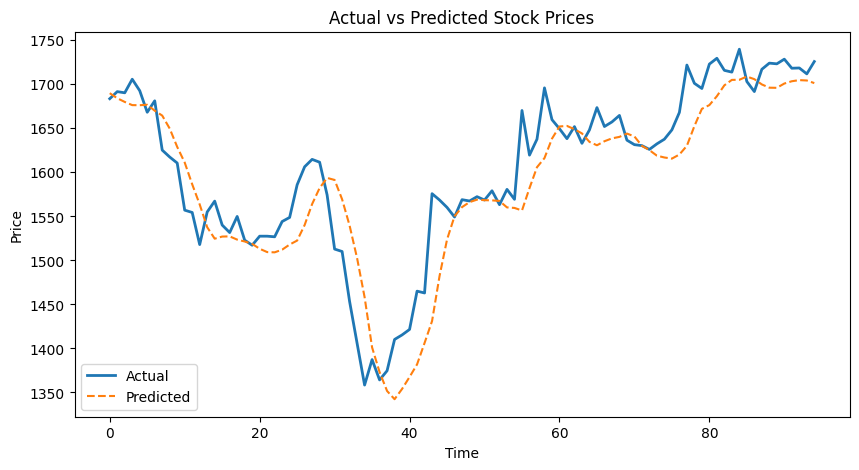

In [20]:
#plot actual vs predicted

y_pred = model.predict(X_test)

# Create dummy arrays for 'Open' and 'High' with the same shape as y_pred/y_test
dummy_open = np.zeros_like(y_pred)
dummy_high = np.zeros_like(y_pred)

# Combine predicted/actual 'Close' with dummy 'Open' and 'High'
y_pred_combined = np.hstack((dummy_open, dummy_high, y_pred))
y_test_combined = np.hstack((dummy_open, dummy_high, y_test.reshape(-1, 1)))

# Inverse transform the combined arrays
y_pred_inv = hcl_scaler.inverse_transform(y_pred_combined)[:, 2] # Extract the inverse transformed 'Close'
y_test_inv = hcl_scaler.inverse_transform(y_test_combined)[:, 2] # Extract the inverse transformed 'Close'

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
model.save('/content/drive/MyDrive/Colab Notebooks/HCL_model.keras')

In [24]:
import joblib
joblib.dump(hcl_scaler, "/content/drive/MyDrive/Colab Notebooks/hcl_scaler.save")

['/content/drive/MyDrive/Colab Notebooks/hcl_scaler.save']

In [25]:
import json

metrics = {
    "val_loss": float(history.history['val_loss'][-1]),
    "val_mae": float(history.history['val_mae'][-1]),
    "train_loss": float(history.history['loss'][-1]),
    "train_mae": float(history.history['mae'][-1]),
    "epochs": len(history.history['loss']),
    "model_name": "HCL_model.keras"
}

with open('/content/drive/MyDrive/Colab Notebooks/HCL_model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
